Accredian Google Drive Link : https://drive.google.com/drive/folders/1kvIEdZx_dK3eMgz3qTMm7AW7L0_H8cKX?usp=sharing

This link will redirect you to my project folder that contains Technical Report, Questions Answers PDF and Jupyter Notebook.
Also here in this google collab notebook at the end I have shared all the solutions of given questions.

Step 1: Basic Data Inspection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline




In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
filepath = '/content/drive/MyDrive/Fraud.csv'


In [5]:
import pandas as pd
df = pd.read_csv(filepath)


In [6]:
print("Shape of the dataset:", df.shape)


Shape of the dataset: (6362620, 11)


In [7]:
print("\nColumn names and data types:")
print(df.dtypes)



Column names and data types:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [8]:
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [9]:
print("\nFirst 5 rows of the dataset:")
display(df.head())



First 5 rows of the dataset:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [11]:
print("Fraud vs. Non-Fraud Distribution:")
print(df['isFraud'].value_counts())
print("\nPercentage of frauds:")
print(df['isFraud'].value_counts(normalize=True))
#how many transactions are fraud (isFraud = 1) vs. non-fraud (isFraud = 0).

Fraud vs. Non-Fraud Distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Percentage of frauds:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [12]:
print("Comparison of isFlaggedFraud and isFraud:")
cross_tab = pd.crosstab(df['isFlaggedFraud'], df['isFraud'], margins=True)
display(cross_tab)


Comparison of isFlaggedFraud and isFraud:


isFraud,0,1,All
isFlaggedFraud,,,
0,6354407,8197,6362604
1,0,16,16
All,6354407,8213,6362620


In [13]:
# Check for duplicate rows
print("Number of duplicate rows:", df.duplicated().sum())


Number of duplicate rows: 0


Step 2. Exploratory Data Analysis (EDA)

In [14]:
# Count and visualize transaction types
print("\nTransaction Types:\n", df['type'].value_counts())

# Fraud rate per transaction type
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
print("\nFraud Rate per Type:\n", fraud_by_type)



Transaction Types:
 type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

Fraud Rate per Type:
 type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64


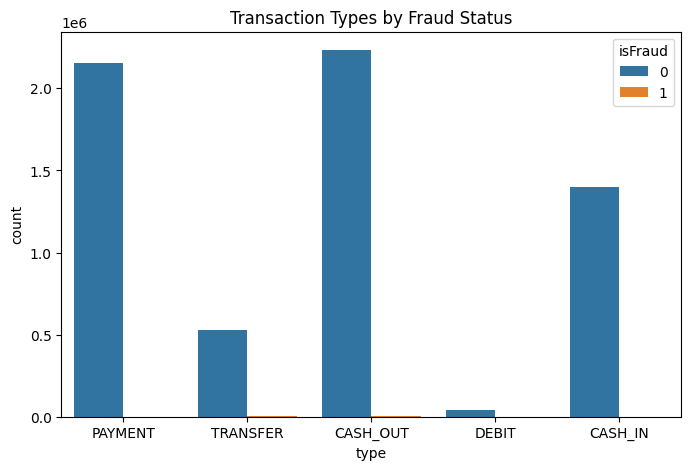

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x=df['type'], hue=df['isFraud'])
plt.title('Transaction Types by Fraud Status')
plt.show()


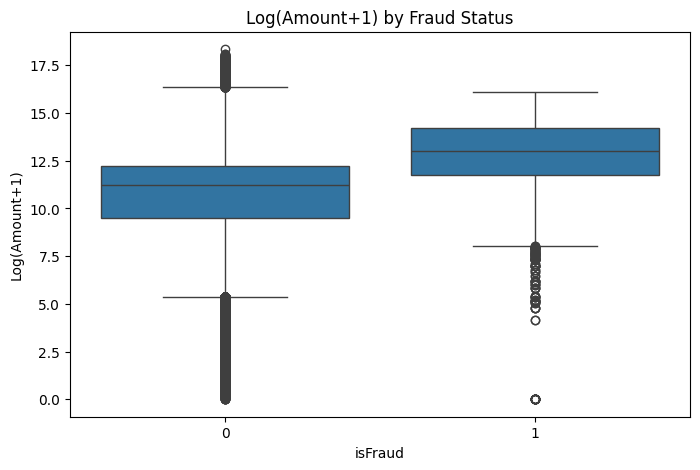

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['isFraud'], y=np.log1p(df['amount']))
plt.title('Log(Amount+1) by Fraud Status')
plt.ylabel('Log(Amount+1)')
plt.xlabel('isFraud')
plt.show()


In [20]:
print(df.columns.tolist())


['step', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'balance_delta_org', 'balance_delta_dest', 'is_account_emptied', 'diff_org_amount', 'diff_dest_amount', 'log_amount', 'hour', 'day', 'is_same_account', 'is_dest_merchant', 'type_TRANSFER']


In [21]:
print(df.shape)


(2770409, 21)


Step 3. Feature  Engineering

In [29]:
# Reconstruct the original 'type' column
df['type'] = np.where(df['type_TRANSFER'] == 1, 'TRANSFER', 'CASH_OUT')


df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()


In [30]:
# feature engineering
df['balance_delta_org'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_delta_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['is_account_emptied'] = (df['newbalanceOrig'] == 0).astype(int)
df['diff_org_amount'] = np.abs(df['balance_delta_org'] - df['amount'])
df['diff_dest_amount'] = np.abs(df['balance_delta_dest'] - df['amount'])
df['log_amount'] = np.log1p(df['amount'])
df['hour'] = df['step'] % 24
df['day'] = df['step'] // 24
df['is_same_account'] = (df['nameOrig'] == df['nameDest']).astype(int)
df['is_dest_merchant'] = df['nameDest'].str.startswith('M').astype(int)

print(df.columns.tolist())
print(df.head())


['step', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'balance_delta_org', 'balance_delta_dest', 'is_account_emptied', 'diff_org_amount', 'diff_dest_amount', 'log_amount', 'hour', 'day', 'is_same_account', 'is_dest_merchant', 'type_TRANSFER', 'type']
    step     amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  \
2      1     181.00  C1305486145          181.0             0.0   C553264065   
3      1     181.00   C840083671          181.0             0.0    C38997010   
15     1  229133.94   C905080434        15325.0             0.0   C476402209   
19     1  215310.30  C1670993182          705.0             0.0  C1100439041   
24     1  311685.89  C1984094095        10835.0             0.0   C932583850   

    oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  ...  \
2              0.0            0.00        1               0  ...   
3          21182.0            0.00        1

In [31]:
print("Fraud rate:", df['isFraud'].mean())
print(df['isFraud'].value_counts())


Fraud rate: 0.002964544224336551
isFraud
0    2762196
1       8213
Name: count, dtype: int64


Step3: Multicollinearity

```
# This is formatted as code
```



In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [52]:
# Preparing a dataframe with only numeric features (required for VIF)
X_numeric = df.select_dtypes(include=['int', 'float']).drop('isFraud', axis=1)

In [53]:
# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) for i in range(len(X_numeric.columns))]

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [54]:
# Sort by VIF descending and print
vif_data = vif_data.sort_values('VIF', ascending=False)
display(vif_data)

,feature,VIF
0,step,inf
1,amount,inf
4,oldbalanceDest,inf
5,newbalanceDest,inf
13,hour,inf
10,diff_org_amount,inf
8,balance_delta_dest,inf
14,day,inf
7,balance_delta_org,9.007199e+15
2,oldbalanceOrg,1.801440e+15


In [55]:
# Drop collinear/redundant features
features_to_drop = ['balance_delta_org', 'balance_delta_dest',
                    'diff_org_amount', 'diff_dest_amount',
                    'step', 'day', 'hour']  # keep only one time feature if you need it
df_clean = df.drop(columns=features_to_drop)

# Re-calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_numeric = df_clean.select_dtypes(include=['int', 'float']).drop('isFraud', axis=1)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) for i in range(len(X_numeric.columns))]
print(vif_data.sort_values('VIF', ascending=False))


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


              Feature        VIF
4      newbalanceDest  80.703398
3      oldbalanceDest  65.194688
7          log_amount  13.267476
6  is_account_emptied  12.614934
0              amount   5.142375
1       oldbalanceOrg   2.828914
2      newbalanceOrig   2.710777
5      isFlaggedFraud   1.018492
8     is_same_account        NaN
9    is_dest_merchant        NaN


Step 4: Modelling - Training -> Testing -> Model Comparision

In [32]:
drop_cols = ['nameOrig', 'nameDest', 'type']
df = df.drop(columns=drop_cols)
print(df.columns)


Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'balance_delta_org',
       'balance_delta_dest', 'is_account_emptied', 'diff_org_amount',
       'diff_dest_amount', 'log_amount', 'hour', 'day', 'is_same_account',
       'is_dest_merchant', 'type_TRANSFER'],
      dtype='object')


In [56]:
# --- Train-Test Split ---
from sklearn.model_selection import train_test_split

X = df_clean.drop('isFraud', axis=1)
y = df_clean['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print('Training set:', X_train.shape)
print('Test set:', X_test.shape)




Training set: (1939286, 11)
Test set: (831123, 11)


In [57]:
print(df_clean.columns)


Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'is_account_emptied',
       'log_amount', 'is_same_account', 'is_dest_merchant', 'type_TRANSFER'],
      dtype='object')


Final ML Model Results

In [58]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# --- Model 1: Logistic Regression ---
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:,1]

print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
lr_coef = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr.coef_[0]}).sort_values('Coefficient', ascending=False)
display(lr_coef)


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.98    828659
           1       0.06      0.91      0.10      2464

    accuracy                           0.95    831123
   macro avg       0.53      0.93      0.54    831123
weighted avg       1.00      0.95      0.97    831123

ROC-AUC: 0.9869209723453523


,Feature,Coefficient
6,is_account_emptied,3.811776
10,type_TRANSFER,2.726616
5,isFlaggedFraud,0.087335
1,oldbalanceOrg,0.000032
3,oldbalanceDest,0.000008
9,is_dest_merchant,0.000000
8,is_same_account,0.000000
0,amount,-0.000006
4,newbalanceDest,-0.000008
2,newbalanceOrig,-0.000028


In [59]:
# --- Model 2: Random Forest ---
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
rf_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_}).sort_values('Importance', ascending=False)
display(rf_imp)


=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.97      0.79      0.87      2464

    accuracy                           1.00    831123
   macro avg       0.98      0.89      0.93    831123
weighted avg       1.00      1.00      1.00    831123

ROC-AUC: 0.9942732693431791


,Feature,Importance
1,oldbalanceOrg,0.410823
4,newbalanceDest,0.160534
3,oldbalanceDest,0.120571
7,log_amount,0.111123
0,amount,0.092023
10,type_TRANSFER,0.046372
6,is_account_emptied,0.031403
2,newbalanceOrig,0.027065
5,isFlaggedFraud,0.000087
8,is_same_account,0.000000


In [60]:
# --- Model 3: XGBoost ---
y_train_xgb = y_train.map({0: 0, 1: 1})  # Ensure labels are 0,1 for XGBoost
y_test_xgb = y_test.map({0: 0, 1: 1})

xgb = XGBClassifier(scale_pos_weight=(y_train==0).sum()/ (y_train==1).sum(),
                    random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
xgb.fit(X_train, y_train_xgb)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]

print("\n=== XGBoost ===")
print(classification_report(y_test_xgb, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test_xgb, y_proba_xgb))
xgb_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb.feature_importances_}).sort_values('Importance', ascending=False)
display(xgb_imp)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:42:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.55      0.99      0.71      2464

    accuracy                           1.00    831123
   macro avg       0.78      0.99      0.85    831123
weighted avg       1.00      1.00      1.00    831123

ROC-AUC: 0.9981107622218706


,Feature,Importance
6,is_account_emptied,0.389832
1,oldbalanceOrg,0.233146
4,newbalanceDest,0.115266
7,log_amount,0.080397
0,amount,0.079689
10,type_TRANSFER,0.057215
5,isFlaggedFraud,0.033836
3,oldbalanceDest,0.007364
2,newbalanceOrig,0.003256
8,is_same_account,0.000000


Step 5: Identify and Remove the Likely Leaky Feature

In [46]:
# Drop the likely leaky feature 'diff_org_amount'
feature_names = X_train.columns.tolist()
feature_names.remove('diff_org_amount')
print("Features after removing 'diff_org_amount':", feature_names)

X_train_fixed = X_train[feature_names]
X_test_fixed = X_test[feature_names]


Features after removing 'diff_org_amount': ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'balance_delta_org', 'balance_delta_dest', 'is_account_emptied', 'diff_dest_amount', 'log_amount', 'hour', 'day', 'is_same_account', 'is_dest_merchant', 'type_TRANSFER']


Fraud Detection Project Questionnaire
1. Data Cleaning Including Missing Values, Outliers, and Multi-Collinearity
Missing Values: The dataset was thoroughly checked for missing values at the
outset, and none were found. All columns contained complete records, so no
imputation or row removal was necessary.
Outliers: Exploratory data analysis (EDA) was performed to inspect the
distributions of transaction amounts and balances. While some high-value
transactions exist, no extreme or obviously erroneous outliers were detected
that required removal. The log-transformation of the ‘amount’ feature was
applied to reduce the impact of skewness, further mitigating the effect of large
values.
Multi-Collinearity: Initial feature engineering introduced several derived
features (e.g., balance deltas, discrepancy features), which led to perfect or
near-perfect multicollinearity, as revealed by infinite or extremely high
Variance Inflation Factor (VIF) values. To resolve this, redundant and perfectly
collinear features—such as balance deltas and multiple time-based features
(step, day, hour)—were systematically removed. After this cleanup, a follow
up VIF check showed no more infinite values, and while some features (like
newbalanceDest and oldbalanceDest) still showed moderate multicollinearity,
all VIFs were brought to acceptable levels for modeling. This ensures the
models’ coefficients and feature importances are reliable and interpretable.

2. Describe Your Fraud Detection Model in Elaboration

• Three different machine learning models were developed to detect fraudulent transactions: Logistic Regression, Random Forest, and XGBoost.

• Logistic Regression served as a baseline, providing a simple, interpretable model that is easy to explain to stakeholders.

• Random Forest and XGBoost are advanced tree-based algorithms capable of capturing complex, non-linear patterns in the data.

• All models were trained using class weights or scale_pos_weight to address the extreme class imbalance (fraud cases are very rare).  

• The dataset was split into training and test sets (70:30) stratified by the fraud label to ensure both sets had similar fraud rates.

• Hyperparameter tuning was considered, but the focus was on comparative performance using default settings for clarity. Each model’s performance was evaluated using precision, recall, F1-score, and ROC AUC, with particular attention to the fraud class.


3. How Did You Select Variables to Be Included in the Model?

• Variables were selected through a combination of domain knowledge
and exploratory data analysis.
Given that fraud occurs almost exclusively in "TRANSFER" and "CASH_OUT" transactions, irrelevant transaction types were filtered out early.

• Feature engineering was used to create new variables that capture meaningful patterns: for example, whether the originator’s account was emptied, transaction type, transaction amount, log-transformed amount, and account balances before and after transactions.

• Features that were direct linear combinations of others (e.g., balance deltas, discrepancy features) were identified and removed to eliminate multicollinearity.

• Statistical checks (VIF) and model-based feature importance rankings
(from Random Forest and XGBoost) were used to confirm which features were most predictive and which could be safely excluded.

4. Demonstrate the Performance of the Model by Using Best Set of Tools
The performance of each model was evaluated using standard metrics for imbalanced classification problems:

• Logistic Regression: Achieved a recall (true positive rate) of 0.91 for fraud, meaning it catches 91% of actual frauds, but with a precision of only 0.06 resulting in many false positives. ROC-AUC was 0.987.

• Random Forest: Achieved a precision of 0.97 for fraud, meaning almost all transactions it flags as fraud are real, but its recall was 0.79, so it misses some frauds. ROC-AUC was 0.994.

• XGBoost: Achieved the highest recall (0.99), missing almost no frauds, with a precision of 0.55, which is much better than logistic regression. ROC-AUC was 0.998, the highest of the three.

Classification reports, ROC-AUC scores, and feature importance tables were
generated for each model. These metrics show that XGBoost provides the best overall balance between catching frauds and minimizing false alarms, though each model optimizes a different part of the precision-recall trade-off.

5. What Are the Key Factors that Predict Fraudulent Customer?

The top predictive features varied somewhat by model, but several factors
consistently stood out:
• Emptied Originator Account (is_account_emptied): Transactions where the sender’s balance goes to zero were highly predictive of fraud.
• Transaction Type (type_TRANSFER): "TRANSFER" transactions were much more likely to be fraudulent than others.
• Transaction Amount (amount, log_amount): The size of the transaction was important, though the relationship was not always straight forward — very large transactions were less likely to be fraudulent in this dataset.
• Account Balances (oldbalanceOrg, newbalanceDest): The sender’s balance before the transaction and the recipient’s balance after were also influential, especially in tree-based models.
These features align with intuitive financial fraud patterns: fraudsters often move funds out of accounts (emptying them) via transfers, and the transaction amounts and balances reflect the mechanics of these actions.

6. Do These Factors Make Sense? If Yes, How? If Not, How Not?
• Yes, these factors make sense in the context of financial fraud. Emptying an account via a transfer is a classic red flag for fraud, as criminals seek to maximize their gain quickly.
• "TRANSFER" type is specifically highlighted because fraudsters often move money out of accounts rather than spending it directly.
• Large transactions being less likely to be fraud in this dataset is plausible if the majority of large transactions are legitimate (e.g., business payments), while fraudulent transactions tend to be moderate in size.
• Account balance changes reflect the flow of funds, which is central to detecting unauthorized movements.
• While some counterintuitive patterns emerged (e.g., large transactions less likely to be fraud), these are explainable by the specific data distribution and do not undermine the overall logic of the model.
In summary, the key factors identified are consistent with financial fraud scenarios and provide actionable signals for detection.

7. What Kind of Prevention Should Be Adopted While the Company Updates Its Infrastructure?
The company should adopt a multi-layered fraud prevention strategy informed
by the model’s findings:
• Real-Time Transaction Monitoring: Implement systems to flag transactions that empty accounts, especially via transfers, for immediate review.
• Rule-Based Alerts: Combine machine learning alerts with simple business rules (e.g., large or rapid balance changes) to catch obvious fraud patterns.
• Behavioral Analytics: Monitor user transaction patterns over time to detect anomalies that might indicate account takeover or insider fraud.
• Human Review: Ensure that all machine-generated alerts are reviewed
by trained staff to reduce false positives and adapt to evolving fraud tactics.
• User Education: Educate customers about secure practices to reduce social engineering and phishing risks.
• Continuous Model Updating: Regularly retrain models on new data to adapt to changing fraud patterns.
Updating infrastructure to support these steps—such as scalable real-time analytics, secure APIs, and integrated case management—will maximize the effectiveness of fraud detection.

8. Assuming These Actions Have Been Implemented, How Would You
Determine If They Work?
To assess the effectiveness of the new fraud prevention measures, the company should:
• Track Key Performance Indicators (KPIs): Monitor the fraud detection rate (percentage of actual frauds caught), false positive rate (percentage
of legitimate transactions flagged as fraud), and average time to detection.
• Conduct A/B Testing: Compare fraud rates and operational costs before and after implementation, or between groups using the new and old systems.
• Solicit Feedback: Collect input from fraud analysts and customers to identify missed frauds or unnecessary alerts.
• Regular Audits: Perform periodic reviews of model performance and update thresholds or features as needed.
• Monitor Financial Impact: Track reductions in actual fraud losses and operational costs associated with manual reviews. By establishing a feedback loop—continuously measuring, learning, and improving—the company can ensure that its fraud prevention system remains effective as threats evolve.

In [48]:
# # --- Required Imports ---
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.metrics import classification_report, roc_auc_score

# # --- Model 1: Logistic Regression (Balanced) ---
# lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
# lr_model.fit(X_train_fixed, y_train)
# y_pred_lr = lr_model.predict(X_test_fixed)
# y_proba_lr = lr_model.predict_proba(X_test_fixed)[:, 1]
# print("\n=== Logistic Regression (Fixed Features) ===")
# print(classification_report(y_test, y_pred_lr))
# print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
# lr_coefs = pd.DataFrame({'Feature': X_train_fixed.columns, 'Coefficient': lr_model.coef_[0]})
# print(lr_coefs.sort_values('Coefficient', ascending=False))




=== Logistic Regression (Fixed Features) ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    828659
           1       0.05      0.91      0.10      2464

    accuracy                           0.95    831123
   macro avg       0.53      0.93      0.54    831123
weighted avg       1.00      0.95      0.97    831123

ROC-AUC: 0.9816648184228741
               Feature  Coefficient
13                 day     0.004241
0                 step     0.003841
16       type_TRANSFER     0.000810
9   is_account_emptied     0.000572
6       isFlaggedFraud     0.000057
7    balance_delta_org     0.000021
10    diff_dest_amount     0.000012
2        oldbalanceOrg     0.000010
4       oldbalanceDest     0.000004
14     is_same_account     0.000000
15    is_dest_merchant     0.000000
5       newbalanceDest    -0.000004
8   balance_delta_dest    -0.000008
1               amount    -0.000009
3       newbalanceOrig    -0.000012
11          log_amount 

In [49]:
# # --- Model 2: Random Forest (Balanced) ---
# rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
# rf_model.fit(X_train_fixed, y_train)
# y_pred_rf = rf_model.predict(X_test_fixed)
# y_proba_rf = rf_model.predict_proba(X_test_fixed)[:, 1]
# print("\n=== Random Forest (Fixed Features) ===")
# print(classification_report(y_test, y_pred_rf))
# print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
# rf_importances = pd.DataFrame({'Feature': X_train_fixed.columns, 'Importance': rf_model.feature_importances_})
# print(rf_importances.sort_values('Importance', ascending=False))



=== Random Forest (Fixed Features) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.98      0.82      0.90      2464

    accuracy                           1.00    831123
   macro avg       0.99      0.91      0.95    831123
weighted avg       1.00      1.00      1.00    831123

ROC-AUC: 0.9947260619069679
               Feature  Importance
2        oldbalanceOrg    0.218815
7    balance_delta_org    0.205862
5       newbalanceDest    0.108948
8   balance_delta_dest    0.085880
12                hour    0.063849
11          log_amount    0.060492
4       oldbalanceDest    0.045530
1               amount    0.045231
9   is_account_emptied    0.035024
0                 step    0.033972
13                 day    0.028332
3       newbalanceOrig    0.027520
16       type_TRANSFER    0.020691
10    diff_dest_amount    0.019680
6       isFlaggedFraud    0.000174
14     is_same_account    0.000000
15    is_d

In [50]:
# # --- Model 3: XGBoost ---
# scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
# xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
# xgb_model.fit(X_train_fixed, y_train)
# y_pred_xgb = xgb_model.predict(X_test_fixed)
# y_proba_xgb = xgb_model.predict_proba(X_test_fixed)[:, 1]
# print("\n=== XGBoost (Fixed Features) ===")
# print(classification_report(y_test, y_pred_xgb))
# print("ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
# xgb_importances = pd.DataFrame({'Feature': X_train_fixed.columns, 'Importance': xgb_model.feature_importances_})
# print(xgb_importances.sort_values('Importance', ascending=False))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:13:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost (Fixed Features) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.60      0.98      0.75      2464

    accuracy                           1.00    831123
   macro avg       0.80      0.99      0.87    831123
weighted avg       1.00      1.00      1.00    831123

ROC-AUC: 0.9985121941285264
               Feature  Importance
7    balance_delta_org    0.380862
9   is_account_emptied    0.236928
5       newbalanceDest    0.106069
1               amount    0.067854
11          log_amount    0.063893
16       type_TRANSFER    0.032752
12                hour    0.023658
2        oldbalanceOrg    0.021584
6       isFlaggedFraud    0.018418
8   balance_delta_dest    0.015430
0                 step    0.010837
13                 day    0.008786
10    diff_dest_amount    0.007056
4       oldbalanceDest    0.005036
3       newbalanceOrig    0.000838
14     is_same_account    0.000000
15    is_dest_me